# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/ERA V1/Assignment 10/src'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ERA V1/Assignment 10/src


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transform import *
from model import *
from utils import *
from dataset import cifar10Dataset, get_loader
from train import *
from test import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
SEED = 1

# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [6]:
train_transforms = get_train_transforms()
test_transforms = get_test_transforms()
train_data = cifar10Dataset('./data', train=True, download=True, transform=train_transforms) #
test_data = cifar10Dataset('./data', train=False, download=True, transform=test_transforms) #
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [8]:
# train dataloader and test loader
batch_size = 512
train_loader, test_loader = get_loader(train_data, test_data, batch_size, use_cuda)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Visualizing Some Images

torch.Size([512, 3, 32, 32])
torch.Size([512])


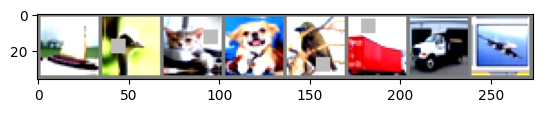

ship  bird  cat   dog   bird  truck truck plane


In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

# Model Params



In [11]:
from model import Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.54E-02


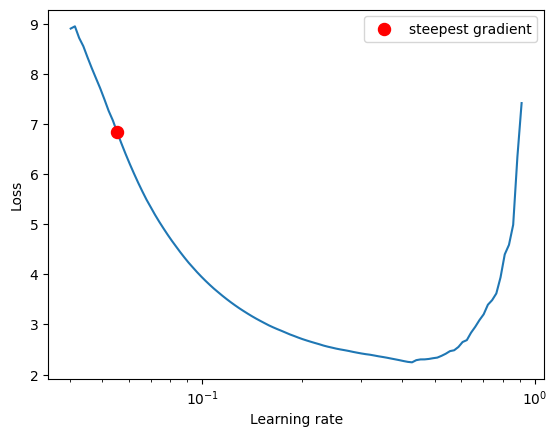

In [12]:
from torch_lr_finder import LRFinder

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# Training and Testing

In [15]:
from torch.optim.lr_scheduler import OneCycleLR
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []
lrs = []
EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=5.54E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.8853055238723755 Batch_id=97 Accuracy=61.43: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]



Test set: Average loss: 0.0023, Accuracy: 6321/10000 (63.21%)

EPOCH: 1


Loss=1.0228111743927002 Batch_id=97 Accuracy=69.99: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0022, Accuracy: 6502/10000 (65.02%)

EPOCH: 2


Loss=0.759768009185791 Batch_id=97 Accuracy=74.00: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]



Test set: Average loss: 0.0017, Accuracy: 7232/10000 (72.32%)

EPOCH: 3


Loss=0.688187837600708 Batch_id=97 Accuracy=76.73: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.0019, Accuracy: 6799/10000 (67.99%)

EPOCH: 4


Loss=0.6378412246704102 Batch_id=97 Accuracy=76.44: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]



Test set: Average loss: 0.0038, Accuracy: 5629/10000 (56.29%)

EPOCH: 5


Loss=0.6215702295303345 Batch_id=97 Accuracy=76.07: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set: Average loss: 0.0022, Accuracy: 6625/10000 (66.25%)

EPOCH: 6


Loss=0.59044349193573 Batch_id=97 Accuracy=76.96: 100%|██████████| 98/98 [00:19<00:00,  5.13it/s]



Test set: Average loss: 0.0016, Accuracy: 7278/10000 (72.78%)

EPOCH: 7


Loss=0.746658980846405 Batch_id=97 Accuracy=77.17: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]



Test set: Average loss: 0.0019, Accuracy: 6802/10000 (68.02%)

EPOCH: 8


Loss=0.6554037928581238 Batch_id=97 Accuracy=77.98: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]



Test set: Average loss: 0.0015, Accuracy: 7455/10000 (74.55%)

EPOCH: 9


Loss=0.7053138017654419 Batch_id=97 Accuracy=78.20: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]



Test set: Average loss: 0.0014, Accuracy: 7576/10000 (75.76%)

EPOCH: 10


Loss=0.6293977499008179 Batch_id=97 Accuracy=78.61: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]



Test set: Average loss: 0.0023, Accuracy: 6082/10000 (60.82%)

EPOCH: 11


Loss=0.5951954126358032 Batch_id=97 Accuracy=79.41: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]



Test set: Average loss: 0.0016, Accuracy: 7237/10000 (72.37%)

EPOCH: 12


Loss=0.6380265355110168 Batch_id=97 Accuracy=79.65: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]



Test set: Average loss: 0.0016, Accuracy: 7311/10000 (73.11%)

EPOCH: 13


Loss=0.5537494421005249 Batch_id=97 Accuracy=80.58: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]



Test set: Average loss: 0.0014, Accuracy: 7498/10000 (74.98%)

EPOCH: 14


Loss=0.5680046677589417 Batch_id=97 Accuracy=80.85: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]



Test set: Average loss: 0.0013, Accuracy: 7750/10000 (77.50%)

EPOCH: 15


Loss=0.6536067128181458 Batch_id=97 Accuracy=81.79: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]



Test set: Average loss: 0.0012, Accuracy: 8028/10000 (80.28%)

EPOCH: 16


Loss=0.6200211644172668 Batch_id=97 Accuracy=82.57: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]



Test set: Average loss: 0.0012, Accuracy: 7945/10000 (79.45%)

EPOCH: 17


Loss=0.5332435965538025 Batch_id=97 Accuracy=83.60: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]



Test set: Average loss: 0.0012, Accuracy: 7995/10000 (79.95%)

EPOCH: 18


Loss=0.4371122121810913 Batch_id=97 Accuracy=84.67: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]



Test set: Average loss: 0.0011, Accuracy: 8115/10000 (81.15%)

EPOCH: 19


Loss=0.3954147696495056 Batch_id=97 Accuracy=85.78: 100%|██████████| 98/98 [00:19<00:00,  5.13it/s]



Test set: Average loss: 0.0010, Accuracy: 8307/10000 (83.07%)

EPOCH: 20


Loss=0.35147982835769653 Batch_id=97 Accuracy=87.17: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]



Test set: Average loss: 0.0010, Accuracy: 8234/10000 (82.34%)

EPOCH: 21


Loss=0.2677292227745056 Batch_id=97 Accuracy=88.74: 100%|██████████| 98/98 [00:18<00:00,  5.18it/s]



Test set: Average loss: 0.0008, Accuracy: 8602/10000 (86.02%)

EPOCH: 22


Loss=0.28968554735183716 Batch_id=97 Accuracy=91.74: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]



Test set: Average loss: 0.0006, Accuracy: 8930/10000 (89.30%)

EPOCH: 23


Loss=0.19745883345603943 Batch_id=97 Accuracy=93.94: 100%|██████████| 98/98 [00:18<00:00,  5.16it/s]



Test set: Average loss: 0.0006, Accuracy: 9000/10000 (90.00%)



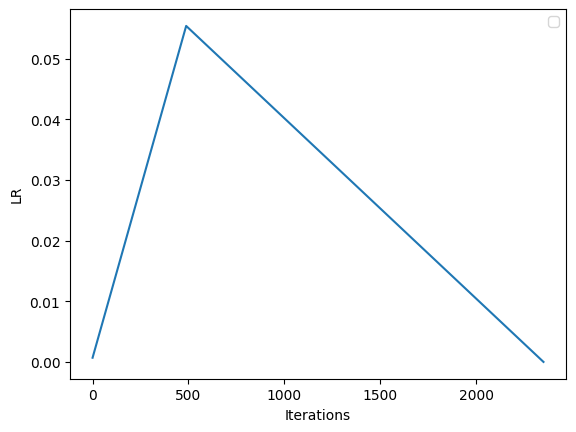

In [16]:
plt.figure()
plt.legend()
plt.plot(lrs, label='OneCycle')
plt.xlabel('Iterations')
plt.ylabel('LR')
plt.show()

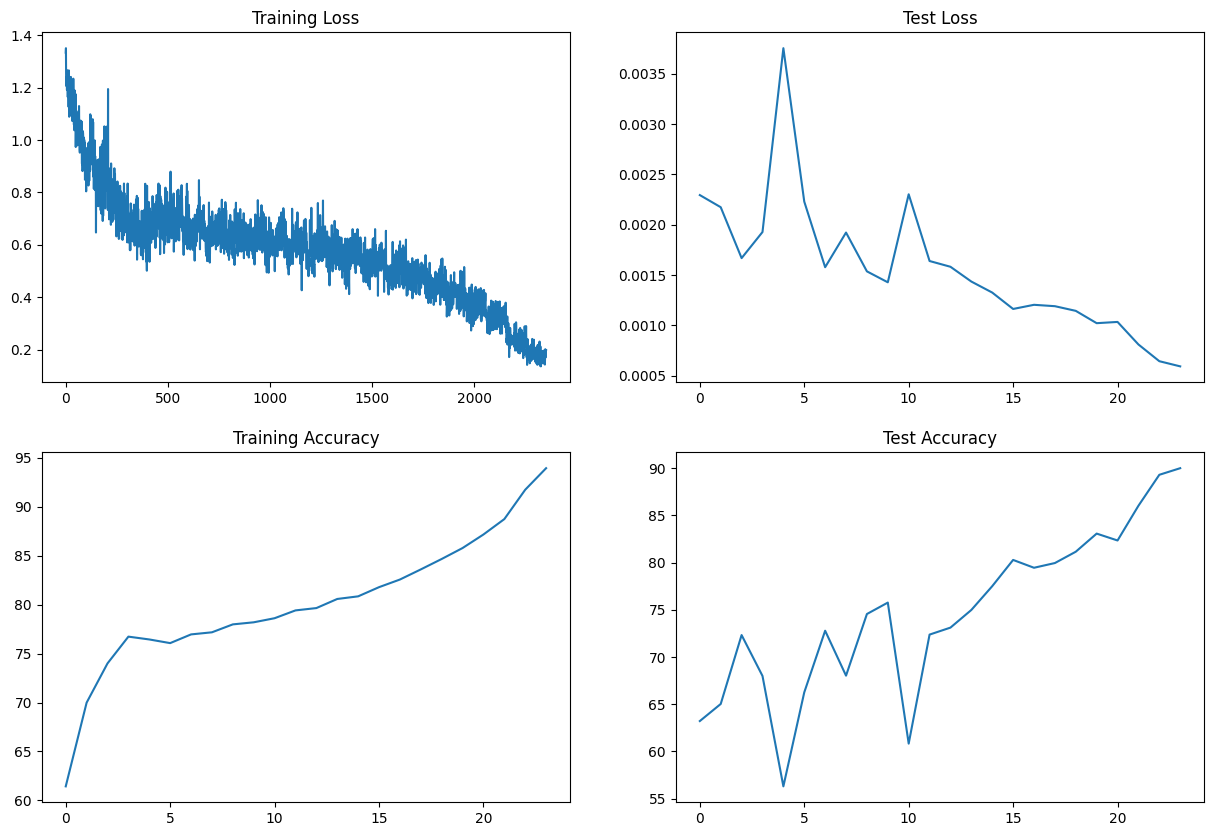

In [17]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)